In [3]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from d2l import torch as d2l
%matplotlib inline

In [4]:
from torch.utils.data import ConcatDataset

In [5]:
datasets = 'F:Kaggle/0-9/'
classes = os.listdir(datasets)

In [6]:
train_trs=torchvision.transforms.Compose([
        transforms.RandomRotation(10),      # rotate 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(40),
        transforms.CenterCrop(40),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [7]:
data = torchvision.datasets.ImageFolder(datasets,transform=train_trs)

In [8]:
print(len(classes))

10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


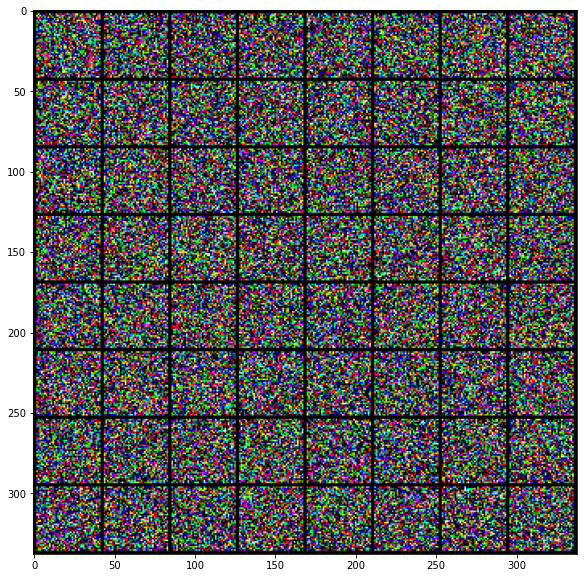

In [9]:
x = torch.randn(64, 3, 40, 40) 

# 使用torchvision.utils.make_grid()来将多个图像拼接成一个网格
grid = torchvision.utils.make_grid(x, nrow=8) # 这里nrow表示每行显示多少个图像

# 使用matplotlib.pyplot.imshow()来显示网格图像
plt.figure(figsize=(10, 10)) 
plt.imshow(grid.permute(1, 2, 0)) # 这里permute是为了将通道维度放到最后一个位置，因为imshow要求输入的形状是（H,W,C）
plt.show() # 这里show是为了显示出图像

In [10]:
# function for the showing the image.
def show_image(img,label):
    plt.imshow(img.permute(1,2,0))
    print(img.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 40, 40])


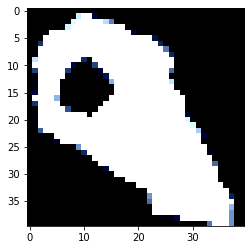

In [11]:
show_image(*data[20])

In [12]:
print(len(data))

3000


In [13]:
train_size = int(0.8 * 3000) 
val_size = int(0.1 * 3000) 
test_size = 3000 - train_size - val_size 
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, val_size, test_size])

In [14]:
print(len(train_dataset))
print(len(test_dataset))

2400
300


In [15]:
batch_size = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
train_val_loader = DataLoader(
    data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

In [21]:
def get_net():
    num_classes = len(classes)
    net = d2l.resnet18(num_classes,3)
    return net
loss = nn.CrossEntropyLoss(reduction='none')

In [22]:
X = torch.rand(size=(64,3,40,40), dtype=torch.float32)
model = get_net()  # create an instance of the model
for layer in model.children():  # iterate over the layers of the instance
    X = layer(X)
    print('output shape:', X.shape)

output shape: torch.Size([64, 64, 40, 40])
output shape: torch.Size([64, 64, 40, 40])
output shape: torch.Size([64, 64, 40, 40])
output shape: torch.Size([64, 64, 40, 40])
output shape: torch.Size([64, 128, 20, 20])
output shape: torch.Size([64, 256, 10, 10])
output shape: torch.Size([64, 512, 5, 5])
output shape: torch.Size([64, 512, 1, 1])
output shape: torch.Size([64, 10])


In [23]:
show_model = d2l.resnet18(num_classes=len(classes))
print(show_model)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (resnet_block1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_block2): Sequential(
   

In [24]:
def train2(net,train_loader,val_loader,num_epochs,lr,wd,
           devices,lr_period,lr_decay):
    trainer = torch.optim.SGD(net.parameters(),lr=lr,momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer,
                                                lr_period,lr_decay)
    num_batches,timer = len(train_loader),d2l.Timer()
    legend = ['train loss','train acc']
    if val_loader is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_loader):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if val_loader is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, val_loader)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if val_loader is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.000, train acc 1.000, valid acc 1.000
733.1 examples/sec on [device(type='cuda', index=0)]


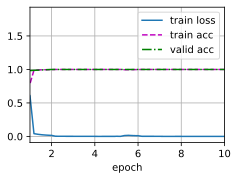

In [30]:
devices,num_epochs,lr,wd = d2l.try_all_gpus(),10,2e-4,5e-4
lr_period , lr_decay,net = 4,0.9,get_net()
train2(net,train_loader,val_loader,num_epochs,lr,wd,
           devices,lr_period,lr_decay)

In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

train loss 0.012, train acc 0.997
754.2 examples/sec on [device(type='cuda', index=0)]


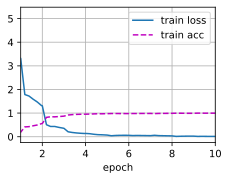

In [28]:
net, preds = get_net(), []
train2(net, train_val_loader, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, y in test_loader:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_dataset) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: classes[x])

In [29]:
from sklearn.metrics import classification_report
pred = []
Y = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        outputs = net(x.cuda()) # convert input tensor to CUDA tensor
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        37
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00        30
           6       1.00      1.00      1.00        39
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        32
           9       1.00      1.00      1.00        23

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [23]:
torch.save(net,'save.pt')

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(6250, 256),  
            nn.ReLU(),            
            nn.Linear(256, 128),  
            nn.ReLU(),            
            nn.Linear(128, 64),           
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, len(classes)))
    def forward(self,x):
        x = self.network(x)
        return x

In [17]:
X = torch.rand(size=(64,3,40,40), dtype=torch.float32)
model = CNN()  # create an instance of the model
for layer in model.children():  # iterate over the layers of the instance
    X = layer(X)
    print('output shape:', X.shape)

output shape: torch.Size([64, 10])


In [18]:
model2 = CNN()

In [19]:
model2.cuda()

CNN(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6250, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features=256,

In [30]:
def get_net2():
    num_classes = len(classes)
    net = CNN()
    return net
loss = nn.CrossEntropyLoss(reduction='none')

In [31]:
def train3(net,train_loader,val_loader,num_epochs,lr,wd,
           devices,lr_period,lr_decay):
    trainer = torch.optim.Adam(net.parameters(),lr=lr,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer,
                                                lr_period,lr_decay)
    num_batches,timer = len(train_loader),d2l.Timer()
    legend = ['train loss','train acc']
    if val_loader is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_loader):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if val_loader is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, val_loader)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if val_loader is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.044, train acc 0.985, valid acc 0.997
934.3 examples/sec on [device(type='cuda', index=0)]


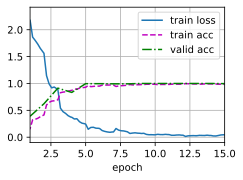

In [32]:
devices,num_epochs,lr,wd = d2l.try_all_gpus(),15,2e-4,5e-4
lr_period , lr_decay,net = 4,0.9,get_net2()
train3(net,train_loader,val_loader,num_epochs,lr,wd,
           devices,lr_period,lr_decay)

train loss 0.017, train acc 0.993
1288.9 examples/sec on [device(type='cuda', index=0)]


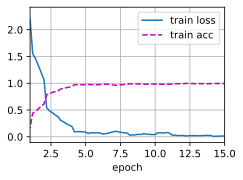

In [33]:
net, preds = get_net2(), []
train3(net, train_val_loader, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, y in test_loader:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_dataset) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: classes[x])

In [34]:
from sklearn.metrics import classification_report
pred = []
Y = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        outputs = net(x.cuda()) # convert input tensor to CUDA tensor
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        26
           3       1.00      1.00      1.00        35
           4       1.00      1.00      1.00        32
           5       0.97      0.97      0.97        36
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        24
           8       0.97      1.00      0.98        29
           9       0.97      1.00      0.98        31

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [108]:
torch.save(net,'save2.pt')